In [1]:
import pandas as pd
from cleaning import create_demand
import pyomo.environ as pyo
import pyomo
import random

# Data import

In [2]:
nodes = pd.read_pickle("../../data/original/nodes.pkl")
channels = pd.read_pickle("../../data/original/channels.pkl")

In [3]:
channels["base_fee"] = channels.loc[:, "base_fee"].apply(lambda x: random.uniform(0,100)) # if x==0 else x)
channels["rate_fee"] = channels.loc[:, "rate_fee"].apply(lambda x: random.uniform(0.001,0.1)) # if x==0 else x)

## Modeling

In [4]:
pyomo.common.timing.report_timing()

In [5]:
# Multiplication to set the same base unit for all computations
channels["capacity"] = channels["capacity"] * 1000000
channels["base_fee"] = channels["base_fee"] * 1000000

In [6]:
model = pyo.ConcreteModel(name="Min cost flow problem")
model.NODES = pyo.Set(initialize=nodes.index)
model.CHANNELS = pyo.Set(initialize=[(channels.loc[i, "node1_pub"], channels.loc[i, "node2_pub"]) for i in channels.index])

           0 seconds to construct Block ConcreteModel; 1 index total
        0.02 seconds to construct Set NODES; 1 index total
        0.24 seconds to construct Set CHANNELS; 1 index total


In [7]:
transaction_amount = 1000000
nodes = create_demand(nodes, transaction_amount,
                      source="02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3",destination="0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08")

Transaction of 1000000 sats.
Sender: VeniceForever
Receiver: ShatSat412.


In [8]:
model.x = pyo.Var(model.CHANNELS, domain=pyo.Binary)
model.a = pyo.Var(model.CHANNELS, domain=pyo.NonNegativeReals, bounds=(0, max(nodes["demand"])))

        0.13 seconds to construct Var x; 89898 indices total
        0.12 seconds to construct Var a; 89898 indices total


In [9]:
channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True)

### Objective function

$$
min \sum_{} ^{} amount_i \times feerate_{i} + x_{i} \times basefee_{i}
$$

In [10]:
#def objective_function(model: pyo.ConcreteModel):
#    return sum(model.a[i] * channels.loc[i, "rate_fee"] for i in model.CHANNELS) + sum(model.x[i] * channels.loc[i, "base_fee"] for i in model.CHANNELS)

def objective_function(model: pyo.ConcreteModel):
    return sum(model.a[i] * channels.loc[i, "rate_fee"] + model.x[i] * channels.loc[i, "base_fee"] for i in model.CHANNELS)

model.totalCost = pyo.Objective(rule=objective_function(model), sense=pyo.minimize)

           0 seconds to construct Objective totalCost; 1 index total


### Constraints

#### Symmetric channel flow rule

This constraint enforces the symmetry between the number of channel incoming and outgoing from an intermediary node (excluding source and destination nodes)

$$
\sum_{(i,n) \in E} x_{i,n} \ge \sum_{(n,j) \in E} x_{n,j} \text{ } \forall n \in V \bigwedge i \notin \{n, s, d\}
$$

where $s$ is the source node, with a negative demand and $d$ is the destination node, with positive demand.

In [11]:
s = nodes[nodes["demand"] < 0].index.values
d = nodes[nodes["demand"] > 0].index.values
intermediaries = [(i, j) for i, j in channels.index if i != s and j != d]

In [12]:
def number_channels_rule(model: pyo.ConcreteModel, n):
    incoming = [model.x[(i, j)] for i, j in intermediaries if j == n]
    outgoing = [model.x[(i, j)] for i, j in intermediaries if i == n]
    return sum(incoming) >= sum(outgoing)

model.NumberChannelsConstraint = pyo.Constraint(model.NODES, rule=number_channels_rule, name="Number channels constraint")

       47.96 seconds to construct Constraint NumberChannelsConstraint; 11984 indices total


#### Capacity constraint

$$amount_{i,j} \le capacity_{i,j} \times x_{i,j} \text{ } \forall (i,j) \in E$$

In [13]:
def capacity_constraint(model: pyo.ConcreteModel, a, b):
    return model.a[(a, b)] <= channels.loc[(a, b), "capacity"] * model.x[(a, b)]

model.CapacityConstraint = pyo.Constraint(model.CHANNELS, rule=capacity_constraint, name="Capacity constraint")

        4.71 seconds to construct Constraint CapacityConstraint; 89898 indices total


#### Flow balance constraint

$$\sum_{(s,i) \in E} amount_{s,i} - \sum_{(i,t) \in E} amount_{i,d} = b_i \text{ } \forall i \in V$$

where $s$ is the source node, $d$ is the destination node, $i$ is every intermediary node


In [14]:
channels.reset_index(inplace=True)
channels.set_index("channel_id", inplace=True)

def flow_balance_constraint(model: pyo.ConcreteModel, n: str):
    InFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'incoming_channels'])
    OutFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'outgoing_channels'])
    return  OutFlow + nodes.loc[n, "demand"] == InFlow

model.FlowBalanceConstraint = pyo.Constraint(model.NODES, rule=flow_balance_constraint, name="Flow balance constrain")

channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True) 

        3.18 seconds to construct Constraint FlowBalanceConstraint; 11984 indices total


## Solving the model

In [15]:
#from pyomo.common.tempfiles import TempfileManager
#TempfileManager.tempdir = "/home/filippo/repositories/LN-pathfinding"

In [16]:
opt = pyo.SolverFactory('cbc')
#opt = pyo.SolverFactory('cplex_direct')
results = opt.solve(model, tee=True, keepfiles=True)

if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print('\nOptimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.feasible:
    print('\nFeasible but not proven optimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    raise Exception("The model is infeasible")
else:
    print('\nSolver Status: ',  results.solver.status)
    raise Exception(results.solver.status)

print('\nObject function value = ', model.Objective())


           0 seconds to construct Var ONE_VAR_CONSTANT; 1 index total
      [    2.14] Generated LP representation
Solver log file: '/tmp/tmpik6rmuzs.cbc.log'
Solver solution file: '/tmp/tmp0c9zf2yi.pyomo.soln'
Solver problem files: ('/tmp/tmp0c9zf2yi.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  9 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp0c9zf2yi.pyomo.lp -stat=1 -solve -solu /tmp/tmp0c9zf2yi.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 107839 (-6027) rows, 173764 (-6032) columns and 514153 (-24067) elements
Statistics for presolved model
Original problem has 89898 integers (89898 of which binary)
Presolved problem has 89871 integers (89871 of which binary)
==== 0 zero objective 173764 different
==== absolute objective values 173764 different
==== for integers 0 zero objective 89871 different
==== for integers absolute objective values 89871 different
===== end objective co

In [17]:
#from pyomo.opt import SolverStatus, TerminationCondition

print("Solver Status: ",  results.solver[0]["System time"])


Solver Status:  1452.12


In [18]:
from decimal import Decimal
pd.set_option('display.max_colwidth', 10000000000000000000000000000000000000000000000000000)
DF_channels = pd.DataFrame()
c = 0
for index, value in model.a.extract_values().items():
    if value > 0.1:
        DF_channels.loc[c, "source"] = index[0]
        DF_channels.loc[c, "destination"] = index[1]
        try:
            DF_channels.loc[c, "source-alias"] = nodes.loc[index[0], "alias"]
        except KeyError:
            print("Source alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "source-alias"] = "source-alias"
            pass
        try:
            DF_channels.loc[c, "destination-alias"] = nodes.loc[index[1], "alias"]
        except KeyError:
            print("Destination alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "destination-alias"] = "destination-alias"
            pass
        DF_channels.loc[c, "capacity"] = Decimal(channels.loc[index, "capacity"]/1000000)
        DF_channels.loc[c, "amount"] = Decimal(value/1000000)
        DF_channels.loc[c, "base_fee"] = Decimal(channels.loc[(index[0], index[1]), "base_fee"]/1000000)
        DF_channels.loc[c, "rate_fee"] = channels.loc[(index[0], index[1]), "rate_fee"]
        #DF_channels.loc[c, "used_fl"] = channels.loc[]
        c += 1

DF_channels_pos = DF_channels[DF_channels["amount"]!=0]

In [19]:
DF_channels[DF_channels["amount"]> DF_channels["capacity"]]

,source,destination,source-alias,destination-alias,capacity,amount,base_fee,rate_fee


In [20]:
DF_fixed = pd.DataFrame()
c = 0
for index, value in model.x.extract_values().items():
    if value != 0:
        DF_fixed.loc[c, "source"] = index[0]
        DF_fixed.loc[c, "destination"] = index[1]
        DF_fixed.loc[c, "used"] = Decimal(value)
        c += 1

DF_fixed_pos = DF_fixed[DF_fixed["used"]!=0]
DF_fixed_pos

,source,destination,used
0,0207ed361128e101a16605fd8e7b491e2d28f7db1677363c9712a3907523a414d2,0364913d18a19c671bb36dd04d6ad5be0fe8f2894314c36a9db3f03c2d414907e1,1
1,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,1
2,0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266,0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08,1
3,021bdd1130960703e0a2c08ebfcac464af42b0643431684a355f4710aa50d022fa,030c3f19d742ca294a55c00376b3b355c3c90d61c6b6b39554dbc7ac19b141c14f,1
4,02287f754427019e74b88c8f3779ce09bcf2c3eefd3e24c1eb7b011b35d9d883af,033e9ce4e8f0e68f7db49ffb6b9eecc10605f3f3fcb3c630545887749ab515b9c7,1
5,0260fab633066ed7b1d9b9b8a0fac87e1579d1709e874d28a0d171a1f5c43bb877,0207ed361128e101a16605fd8e7b491e2d28f7db1677363c9712a3907523a414d2,1
6,026ea7b98d5ac0e8052addfa57fdefb5e504d470e7fd2fb56a5ab68f0fe6677255,037659a0ac8eb3b8d0a720114efc861d3a940382dcfa1403746b4f8f6b2e8810ba,1
7,0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,021bdd1130960703e0a2c08ebfcac464af42b0643431684a355f4710aa50d022fa,1
8,0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,02287f754427019e74b88c8f3779ce09bcf2c3eefd3e24c1eb7b011b35d9d883af,1
9,0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,029efe15ef5f0fcc2fdd6b910405e78056b28c9b64e1feff5f13b8dce307e67cad,1


### All data about channels on path

In [21]:
intersection = DF_fixed_pos.merge(DF_channels_pos, on=["source", "destination"], how="outer")
final = intersection[intersection["amount"]>0]
final

,source,destination,used,source-alias,destination-alias,capacity,amount,base_fee,rate_fee
1,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,1,Eprahs,okx,10000000,1000000,44.23799737234207185565537656657397747039794921875,0.007749
2,0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266,0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08,1,1ML.com node ALPHA,ShatSat412,267599,267599,34.92882981163182165573743986897170543670654296875,0.001735
3,021bdd1130960703e0a2c08ebfcac464af42b0643431684a355f4710aa50d022fa,030c3f19d742ca294a55c00376b3b355c3c90d61c6b6b39554dbc7ac19b141c14f,1,NodeBTC,Bitrefill Routing,3000000,732401,97.376038804653973102176678366959095001220703125,0.005858
4,02287f754427019e74b88c8f3779ce09bcf2c3eefd3e24c1eb7b011b35d9d883af,033e9ce4e8f0e68f7db49ffb6b9eecc10605f3f3fcb3c630545887749ab515b9c7,1,TheSpielplatz,LNBϟG [Hub-2],20201454,100000,13.99372900261121088760774000547826290130615234375,0.004961
7,0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,021bdd1130960703e0a2c08ebfcac464af42b0643431684a355f4710aa50d022fa,1,okx,NodeBTC,4000000,732401,9.517589152265781393680299515835940837860107421875,0.006287
8,0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,02287f754427019e74b88c8f3779ce09bcf2c3eefd3e24c1eb7b011b35d9d883af,1,okx,TheSpielplatz,8000000,100000,89.6934099226428998008486814796924591064453125,0.002360
9,0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,029efe15ef5f0fcc2fdd6b910405e78056b28c9b64e1feff5f13b8dce307e67cad,1,okx,adam.masterofpearls.net,820000000,167599,39.86242422644331639958181767724454402923583984375,0.007918
10,029efe15ef5f0fcc2fdd6b910405e78056b28c9b64e1feff5f13b8dce307e67cad,03a93b87bf9f052b8e862d51ebbac4ce5e97b5f4137563cd5128548d7f5978dda9,1,adam.masterofpearls.net,cyberdyne.sh,20000000,167599,40.3057448482728517547002411447465419769287109375,0.001504
11,02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,1,VeniceForever,Eprahs,1500000,1000000,15.144972467609573385516341659240424633026123046875,0.027109
12,02c746cf01c7f8687f54bc1780a26a74664f22e3ac2724467f103fa2a1450e7c0e,0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266,1,LNJCJNET,1ML.com node ALPHA,100000,100000,52.050851781489740233155316673219203948974609375,0.001430


In [22]:
%%capture --no-stdout
final["amount"] = final["amount"].astype(float)
final["rate_fee"] = final["rate_fee"].astype(float)
final["base_fee"] = final["base_fee"].astype(float)
total_transaction_cost = sum(final["amount"] * final["rate_fee"] + final["base_fee"])
perc_cost = (total_transaction_cost * 100) / transaction_amount
print(f"Transacting {transaction_amount} sats costs {total_transaction_cost} ({perc_cost}% of transaction amount)")

Transacting 1000000 sats costs 52354.32842417347 (5.235432842417347% of transaction amount)


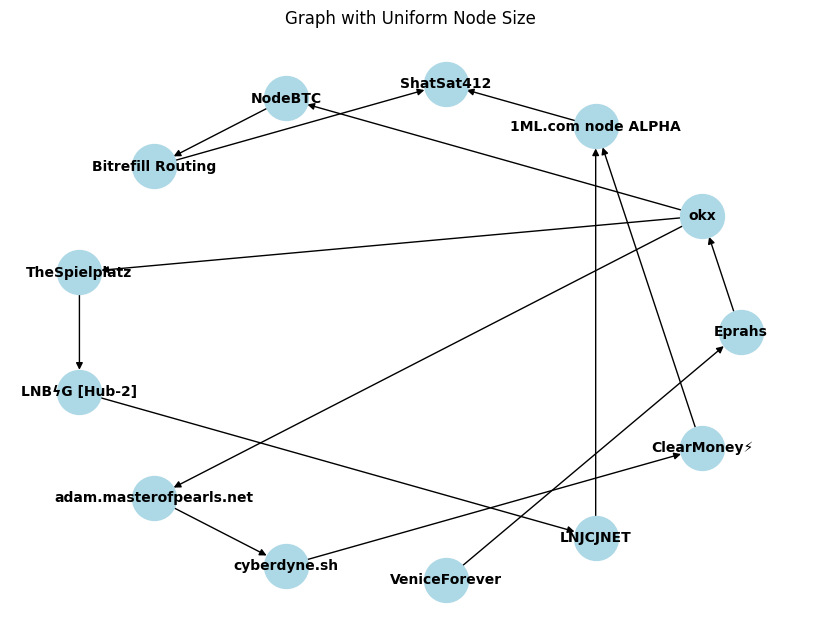

In [23]:

import networkx as nx
import matplotlib.pyplot as plt

# edges list construction
edges_df = final[["source-alias", "destination-alias"]]

G = nx.from_pandas_edgelist(edges_df, "source-alias", "destination-alias", create_using=nx.DiGraph())

plt.figure(figsize=(8, 6))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold', arrows=True)
plt.title("Graph with Uniform Node Size")
plt.show()


In [24]:
for i in nx.strongly_connected_components(G):
    print(i)

{'ShatSat412'}
{'Bitrefill Routing'}
{'NodeBTC'}
{'1ML.com node ALPHA'}
{'LNJCJNET'}
{'LNBϟG [Hub-2]'}
{'TheSpielplatz'}
{'ClearMoney⚡'}
{'cyberdyne.sh'}
{'adam.masterofpearls.net'}
{'okx'}
{'Eprahs'}
{'VeniceForever'}


In [25]:
final
final["amount"] = final["amount"].astype(float)
final["rate_fee"] = final["rate_fee"].astype(float)
final["base_fee"] = final["base_fee"].astype(float)
total_transaction_cost = sum(final["amount"] * final["rate_fee"] + final["base_fee"])
perc_cost = (total_transaction_cost * 100) / transaction_amount
print(f"Transacting {transaction_amount} sats costs {total_transaction_cost} ({perc_cost}% of transaction amount)")
print("Solver Status: ", results.solver[0]["System time"])

Transacting 1000000 sats costs 52354.32842417347 (5.235432842417347% of transaction amount)
Solver Status:  1452.12


/tmp/ipykernel_59573/2595053910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["amount"] = final["amount"].astype(float)
/tmp/ipykernel_59573/2595053910.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["rate_fee"] = final["rate_fee"].astype(float)
/tmp/ipykernel_59573/2595053910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [26]:
#from collections import Counter
#results = [tuple(i) for i in DF_channels_pos[["source-alias", "destination-alias"]].to_numpy()]
#unwrap = [e for i in results for e in i]
#extremes = [j for j in unwrap if Counter(unwrap)[j] == 1]
#def return_source(l: list):
#    if l[0] in [i for i, j in results]:
#        return l[0]
#    else: 
#        return l[1]
#sequence = []        
#source = return_source(extremes)
#sequence.append(source)
#while len(sequence) <= len(results):
#    for i,j in results:
#        if i == sequence[-1]:
#            sequence.append(j)
#for i in sequence:
#    print("⬇️", i)